# Markov State Modelling of PTP1B

This notebook builds and analyses Markov State Models for PTP1B, using `MSMCollection` from AMMo.

## Contents

* [Build MSMs](#Build-MSMs)
* [Bootstrapping](#Bootstrapping)
* [Chapman-Kolmogorov test](#Chapman-Kolmogorov-test)
* [Sampling seeded MD by MSM weights](#Sampling-seeded-MD-by-MSM-weights)
* [Compounds 1 and 2r - F280 $\chi$1 angle](#Compounds-1-and-2r---F280-$\chi$1-angle)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyemma
import pytraj as pt
from ammo.msm import MSMCollection, MSM

## Build MSMs

[top](#Markov-State-Modelling-of-PTP1B)

Load data into `MSMCollection`:

In [3]:
msms = MSMCollection()

In [4]:
locations = []
titles = ['apo', 'reference', '1', '2', '2r', '3', '3u', '4']
for title in titles:
    if title not in ['apo', 'reference']:
        title = f'peptide-{title}'
    locations.append([f'../systems/{title}/open/seeded-md', f'../systems/{title}/closed/seeded-md'])

In [5]:
msms.load_data(titles, locations,
               file_names=['wpd_loop.txt', 'p_loop.txt'],
               features=['WPD loop RMSD/$\AA$', 'P loop RMSD/$\AA$'])

Loading data...
apo MSM
../systems/apo/open/seeded-md
../systems/apo/closed/seeded-md
trajectory 100/100
--------------------
reference MSM
../systems/reference/open/seeded-md
../systems/reference/closed/seeded-md
trajectory 100/100
--------------------
1 MSM
../systems/peptide-1/open/seeded-md
../systems/peptide-1/closed/seeded-md
trajectory 100/100
--------------------
2 MSM
../systems/peptide-2/open/seeded-md
../systems/peptide-2/closed/seeded-md
trajectory 100/100
--------------------
2r MSM
../systems/peptide-2r/open/seeded-md
../systems/peptide-2r/closed/seeded-md
trajectory 100/100
--------------------
3 MSM
../systems/peptide-3/open/seeded-md
../systems/peptide-3/closed/seeded-md
trajectory 100/100
--------------------
3u MSM
../systems/peptide-3u/open/seeded-md
../systems/peptide-3u/closed/seeded-md
trajectory 100/100
--------------------
4 MSM
../systems/peptide-4/open/seeded-md
../systems/peptide-4/closed/seeded-md
trajectory 100/100
--------------------
...done.


Cluster the data into 100 microstates. Optional: use the pre-computed cluster centers to save time.

In [6]:
msms.cluster(centers=np.loadtxt('clusters.txt'))

Plot the reference data with clusters overlayed as an example:

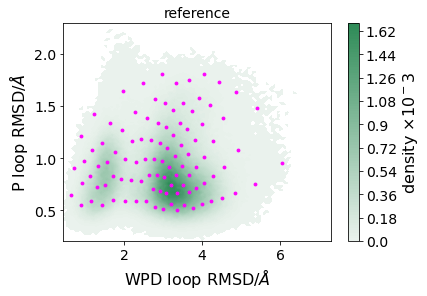

In [7]:
fig, ax, misc = msms['reference'].plot_clusters([msms.clusters.clustercenters])

Assign featurised trajectory data to the clusters from above:

In [8]:
msms.assign_to_clusters()

Compute and plot implied timescales (ITS):

Computing ITS...
apo
reference
1
2
2r
3
3u
4
...done.


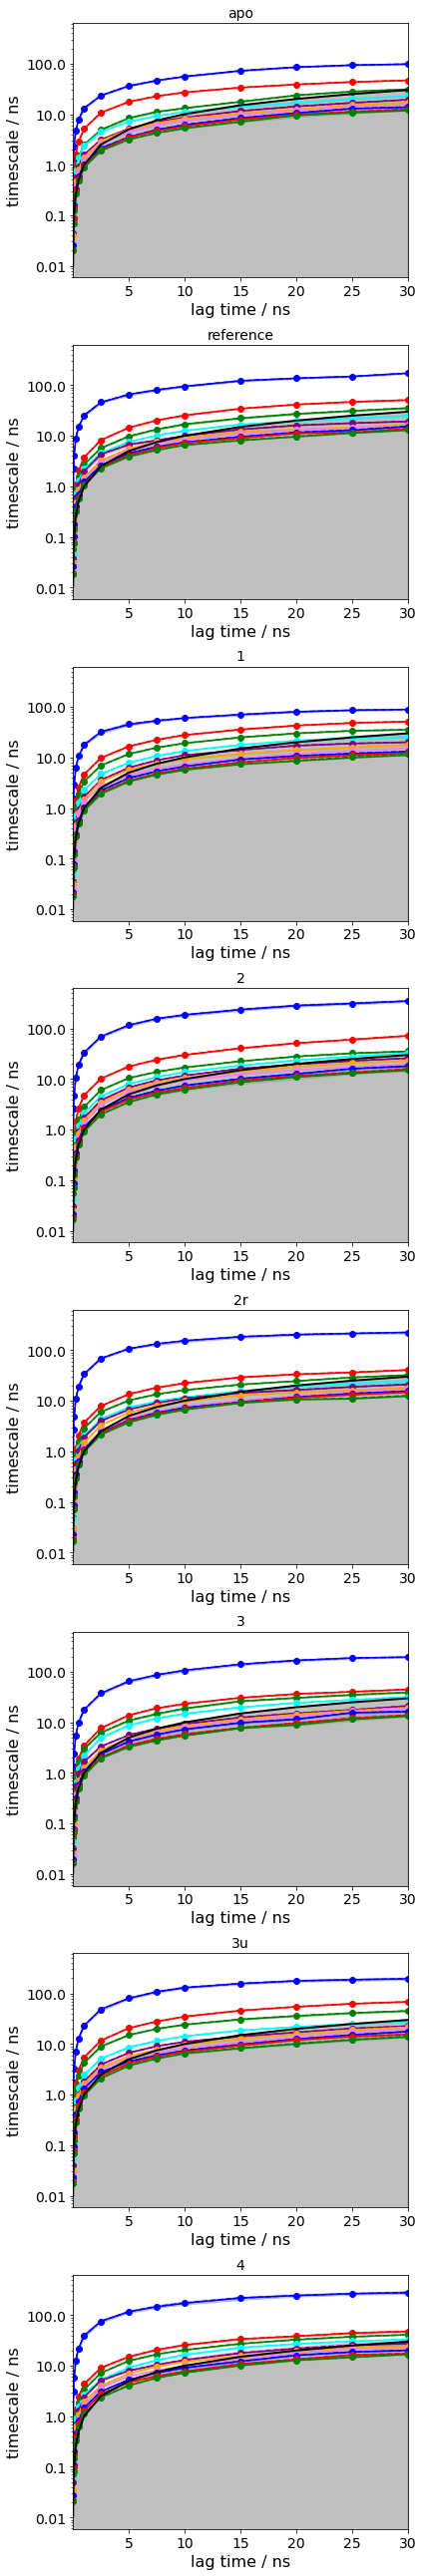

In [9]:
fig, ax = msms.compute_its(time_units='ns')

Build MSMs with a 20 ns lag time, which corresponds to 2000 steps (1 step = 10 ps). PCCA is also run on the reference system MSM, assigning each of the 100 microstate to one of two metastable states. The state with the lower RMSD values is considered active (since the reference structure is the active conformation).

In [10]:
msms.build_msms(2000)
msms.pcca_assignments(2, msm=['reference'], disconnected=1)

Building MSMs...
...done.

Metastable state assignments based on reference MSM, 2 states:
apo
MS 1 has 26 counts and 7.95% probability (± 0.17%)
MS 2 has 74 counts and 92.05% probability (± 1.07%)
--------------------
reference
MS 1 has 26 counts and 25.18% probability (± 0.7%)
MS 2 has 74 counts and 74.82% probability (± 0.74%)
--------------------
1
MS 1 has 26 counts and 5.87% probability (± 0.23%)
MS 2 has 74 counts and 94.13% probability (± 0.77%)
--------------------
2
MS 1 has 26 counts and 40.64% probability (± 1.08%)
MS 2 has 74 counts and 59.36% probability (± 0.56%)
--------------------
2r
MS 1 has 26 counts and 23.08% probability (± 0.53%)
MS 2 has 74 counts and 76.92% probability (± 0.72%)
--------------------
3
MS 1 has 26 counts and 11.86% probability (± 0.38%)
MS 2 has 74 counts and 88.14% probability (± 1.05%)
--------------------
3u
MS 1 has 26 counts and 21.96% probability (± 0.34%)
MS 2 has 74 counts and 78.04% probability (± 0.7%)
--------------------
4
MS 1 has 26

Plot the metastable state assignments on top of reference data:

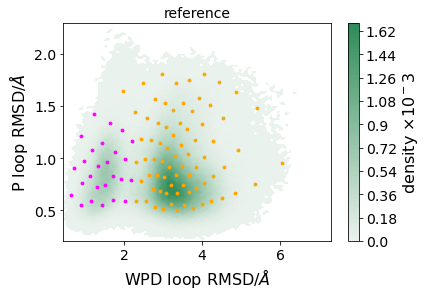

In [11]:
fig, ax, misc = msms['reference'].plot_clusters(msms.get_pcca_clusters(2, 'reference')[0])

## Bootstrapping

[top](#Markov-State-Modelling-of-PTP1B)

Run bootstrapping by resampling on the active state probabilities:

In [ ]:
bootstrapped_probabilities = msms.bootstrapping(2, msm='reference', min_iter=100, max_iter=100)

Bootstrapped probabilities, based on reference MSM, 2 states:
apo
State 1: 8.51% ± 2.2% (100 iterations)
State 2: 91.5% ± 2.2% (100 iterations)
------------------------------
reference
State 1: 24.66% ± 7.31% (100 iterations)
State 2: 75.34% ± 7.31% (100 iterations)
------------------------------
1
State 1: 5.87% ± 1.47% (100 iterations)
State 2: 94.13% ± 1.47% (100 iterations)
------------------------------
2


In [ ]:
msms.save('msm.pkl')

Plot the distributions as a violin plot:

(0.0, 65.183)

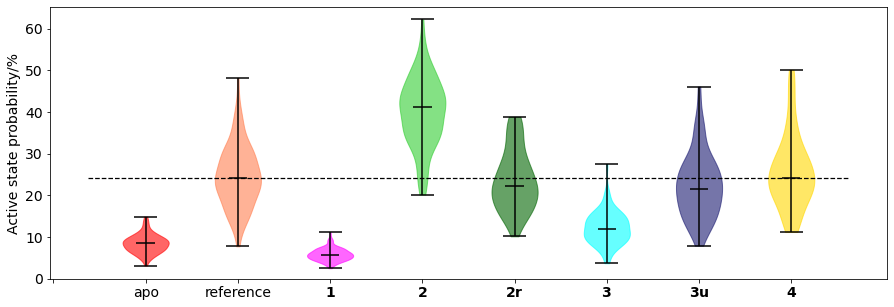

In [25]:
bootstrapping_data = [msms[msm].bootstrapping_data['reference, 2 states']['probabilities'][:,0] for msm in titles]
labels = [None, 'apo', 'reference', r'$\mathbf{1}$', r'$\mathbf{2}$', r'$\mathbf{2r}$', r'$\mathbf{3}$', r'$\mathbf{3u}$', r'$\mathbf{4}$']
colors = ['red', 'coral', 'magenta', 'limegreen', 'darkgreen', 'cyan', 'midnightblue', 'gold']

fig, ax = plt.subplots(1, figsize=(15,5))
violins = ax.violinplot(bootstrapping_data)
for violin, color in zip(violins['bodies'], colors):
    violin.set_color(color)
    violin.set_alpha(0.6)
violins['cmaxes'].set_color('black')
violins['cbars'].set_color('black')
violins['cmins'].set_color('black')

for i, msm in enumerate(titles):
    ax.hlines(np.median(bootstrapping_data[i]), i+0.9, i+1.1, color='black')

ax.hlines(np.median(bootstrapping_data[1]), ax.get_xlim()[0], ax.get_xlim()[1], color='black', linewidth=1.25, linestyles='dashed')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel('Active state probability/%', size=14)
ax.set_ylim(0, None)

(0.0, 68.56782270643492)

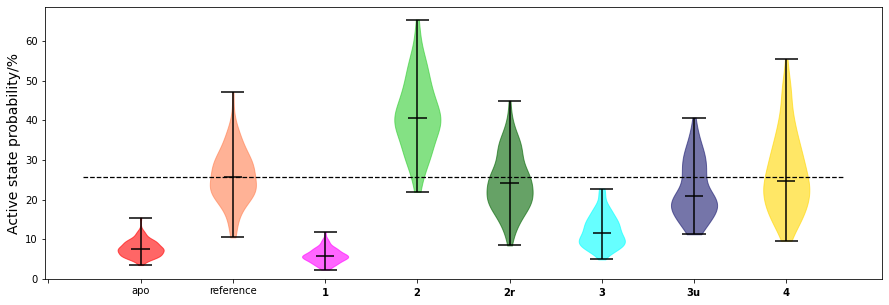

In [15]:
bootstrapping_data = [bootstrapped_probabilities[msm] for msm in titles]
labels = [None, 'apo', 'reference', r'$\mathbf{1}$', r'$\mathbf{2}$', r'$\mathbf{2r}$', r'$\mathbf{3}$', r'$\mathbf{3u}$', r'$\mathbf{4}$']
colors = ['red', 'coral', 'magenta', 'limegreen', 'darkgreen', 'cyan', 'midnightblue', 'gold']

fig, ax = plt.subplots(1, figsize=(15,5))
violins = ax.violinplot(bootstrapping_data)
for violin, color in zip(violins['bodies'], colors):
    violin.set_color(color)
    violin.set_alpha(0.6)
violins['cmaxes'].set_color('black')
violins['cbars'].set_color('black')
violins['cmins'].set_color('black')

for i, msm in enumerate(titles):
    ax.hlines(np.median(bootstrapping_data[i]), i+0.9, i+1.1, color='black')

ax.hlines(np.median(bootstrapped_probabilities['reference']), ax.get_xlim()[0], ax.get_xlim()[1], color='black', linewidth=1.25, linestyles='dashed')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel('Active state probability/%', size=14)
ax.set_ylim(0, None)

## Chapman-Kolmogorov test

[top](#Markov-State-Modelling-of-PTP1B)

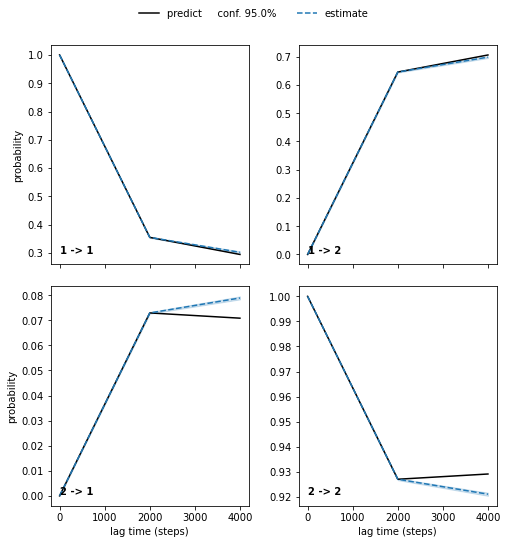

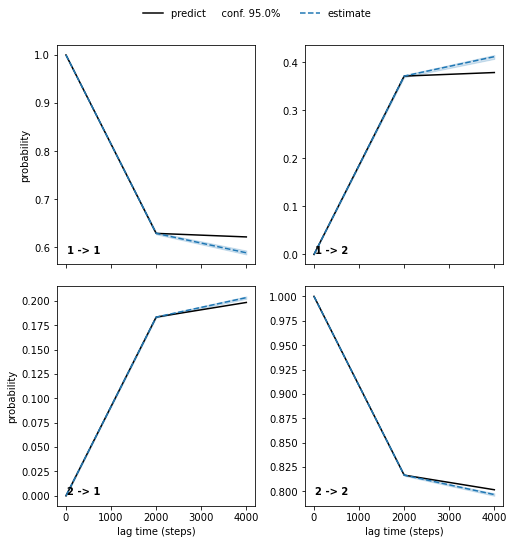

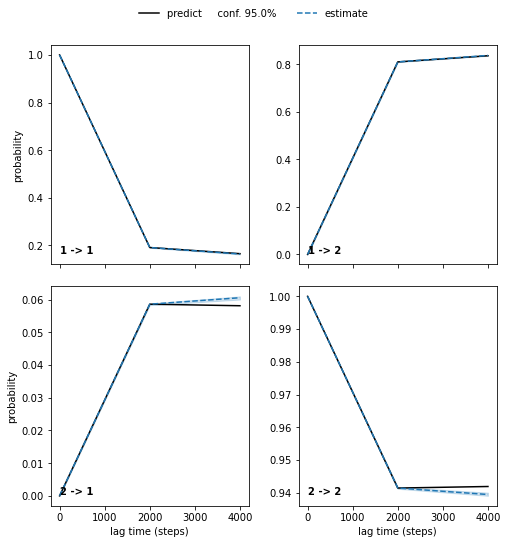

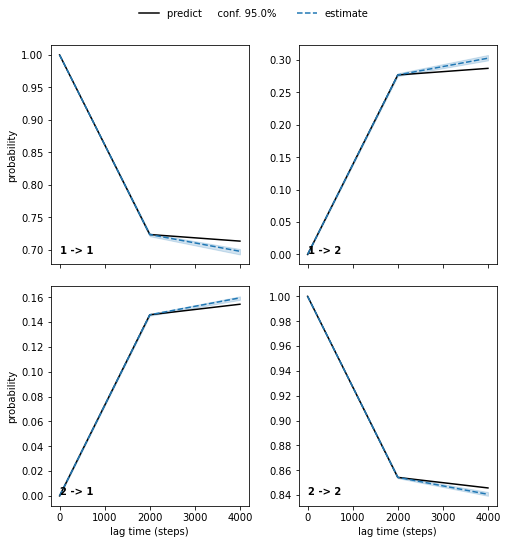

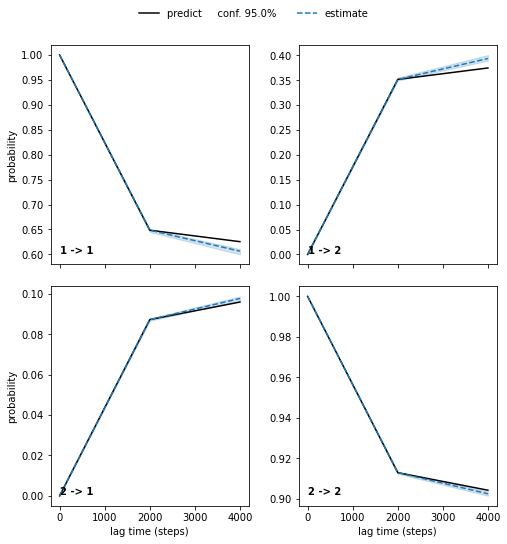

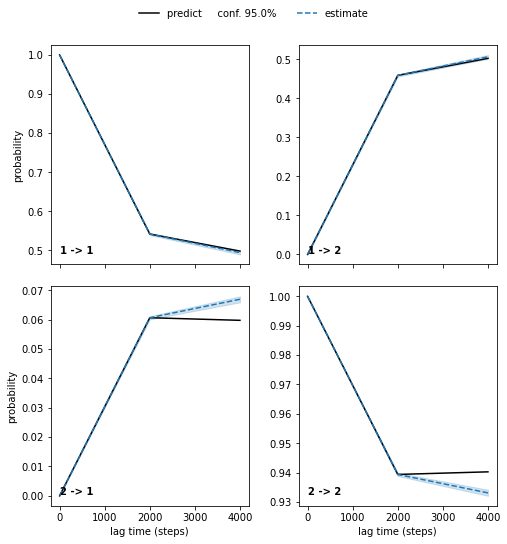

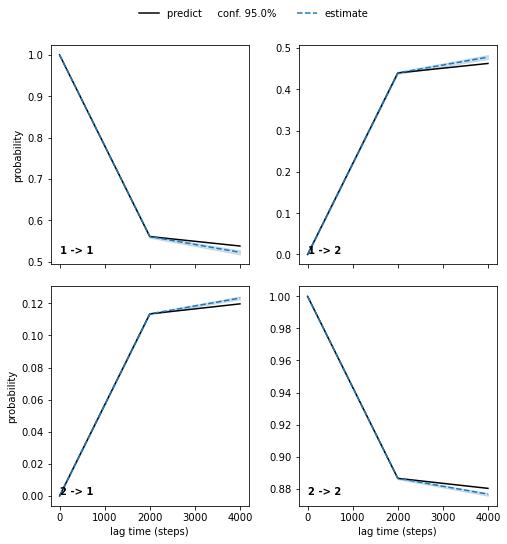

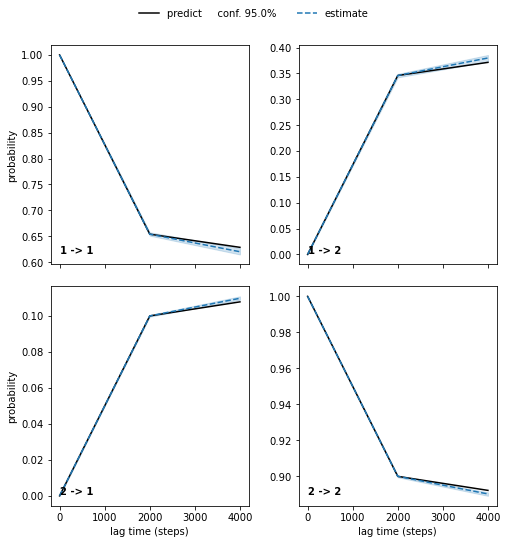

In [25]:
for msm in titles:
    ck = msms.MSMs[msm].msm.cktest(2, mlags=3)
    fig, ax = pyemma.plots.plot_cktest(ck, y01=False, figsize=(8,8))
    fig.subplots_adjust(wspace=0.25, hspace=0.1)

## Sampling seeded MD by MSM weights

[top](#Markov-State-Modelling-of-PTP1B)

The MSMs assign stationary probabilities to each microstate (cluster), and these can be used as weights to pick a smaller sample from the total 10 $\mu$s sampling time, that is representative of system dynamics

In [26]:
msm = msms['reference']

In [ ]:
msm.sample_weighted_trajectories()

In [13]:
for msm in ['1', '2r']:
    output = msm.replace(' ', '_').lower()
    samples = msms[msm].sample_weighted_trajectories(10000, f'../systems/peptide-{msm}/{output}.nc', f'../systems/peptide-{msm}/open/system-setup/system_dry.prm7')

In [27]:
msm.msm.metastable_distributions

BayesianMSM(conf=0.95, connectivity='largest', core_set=None,
      count_mode='effective', dt_traj='1 step', lag=2000,
      milestoning_method='last_core', mincount_connectivity='1/n',
      nsamples=100, nsteps=10, reversible=True, show_progress=False,
      sparse=False, statdist_constraint=None)

Additionally, for the analysis carried out below, the active and inactive state of the reference system was sampled in a similar manner. In this case, the `metastable_distributions` of `pyemma.BayesianMSM` (accessed via `ammo.msm.MSM.msm`) was used, to get the probabilities of the metastable states to belong to a conformation.

In [ ]:
samples = msms['reference'].sample_weighted_trajectories(10000,
                                                         ['../systems/reference/active.nc', '../systems/reference/inactive.nc'],
                                                         '../systems/reference/open/system-setup/system_dry.prm7',
                                                         [msms['reference'].msm.metastable_distributions[0], msms['reference'].msm.metastable_distributions[1]])

## Compounds 1 and 2r - F280 $\chi$1 angle

[top](#Markov-State-Modelling-of-PTP1B)

Load the sampled trajectories:

In [28]:
reference_active = pt.load('../systems/reference/active.nc', top='../systems/reference/open/system-setup/system_dry.prm7')
reference_inactive = pt.load('../systems/reference/inactive.nc', top='../systems/reference/open/system-setup/system_dry.prm7')

In [15]:
cmpd_1 = pt.load('../systems/peptide-1/sample.nc', top='../systems/peptide-1/open/system-setup/system_dry.prm7')
cmpd_2r = pt.load('../systems/peptide-2r/sample.nc', top='../systems/peptide-2r/open/system-setup/system_dry.prm7')

Calculate the Phe280 $\chi$1 angle values for each trajectory:

In [31]:
reference_active_f280 = pt.calc_dihedral(reference_active, ':281@N :281@CA :281@CB :281@CG')
reference_inactive_f280 = pt.calc_dihedral(reference_inactive, ':281@N :281@CA :281@CB :281@CG')

In [17]:
cmpd_1_f280 = pt.calc_dihedral(cmpd_1, ':281@N :281@CA :281@CB :281@CG')
cmpd_2r_f280 = pt.calc_dihedral(cmpd_2r, ':281@N :281@CA :281@CB :281@CG')

Plot reference:

Text(0, 0.5, 'Density')

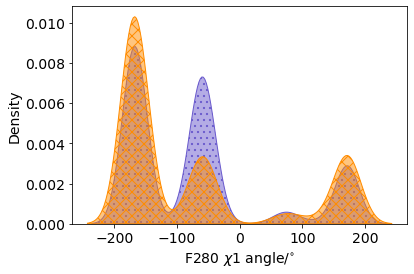

In [32]:
fig, ax = plt.subplots(1)
sns.kdeplot(reference_inactive_f280, color='slateblue', alpha=0.5, hatch='..', shade=True, ax=ax, label='inactive')
sns.kdeplot(reference_active_f280, color='darkorange', alpha=0.5, hatch='xx', shade=True, ax=ax, label='active')
ax.set_xlabel('F280 $\chi$1 angle/$^{\circ}$', size=14)
ax.set_ylabel('Density', size=14)

Plot compounds 1 and 2r:

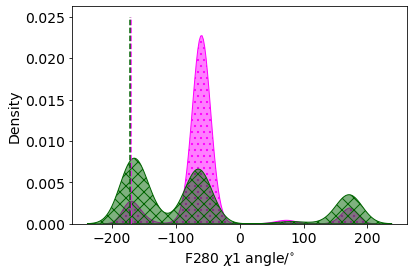

In [27]:
fig, ax = plt.subplots(1)
sns.kdeplot(cmpd_1_f280, color='magenta', alpha=0.5, hatch='..', shade=True, ax=ax, label='FRJ')
sns.kdeplot(cmpd_2r_f280, color='darkgreen', alpha=0.5, hatch='xx', shade=True, ax=ax, label='BB3\n(restrained)')
ax.set_xlabel('F280 $\chi$1 angle/$^{\circ}$', size=14)
ax.set_ylabel('Density', size=14)
ax.vlines(-169.6, 0, 0.025, color='magenta', linestyles='dashed')
ax.vlines(-171.8, 0, 0.025, color='darkgreen', linestyles='dashed')